In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
%matplotlib inline  

In [2]:
#Define wordking directory
cwd = os.getcwd()
print(cwd)

/Users/siegfried/Documents/springboard/capstone1/data_story


This is a study motivated by the line of Amazon’s Echo device with screens, such as Echo Show and Echo Spot. The fundamental question here is: are the Alexa-enabled Echo devices better with a screen? 

This study will investigate the user experience based on Amazon reviews submitted on five Echo products, including three devices with screen and 2 screen-less smart speakers:

Echo Show 1st Generation (with screen, #reviews = 4000)

Echo Show 2nd Generation (with screen, #reviews = 2048)

Echo Spot 1st Generation (with screen, #reviews = 4000)

Echo Plus 1st Generation (screen-less, #reviews = 3208)

Echo Plus 2nd Generation (screen-less, #reviews = 1832)

All reviews were extracted at the end of February, 2019. Up to 4000 reviews were extracted from Amazon for each of the devices.

In [3]:
reviews_echo_show_1stgen = cwd+'/data_scrapping/amazon_reviews_echo_show_1stgen_022819.csv'
reviews_echo_show_2ndgen = cwd+'/data_scrapping/amazon_reviews_echo_show_2ndgen_022819.csv'
reviews_echo_spot = cwd+'/data_scrapping/amazon_reviews_echo_spot_022819_2_n4001.csv'
reviews_echo_plus = cwd+'/data_scrapping/amazon_reviews_echo_plus_022819.csv'
reviews_echo_plus_2ndgen = cwd+'/data_scrapping/amazon_reviews_echo_plus_2ndgen_022819.csv'

reviews_echoshow1 = pd.read_csv(reviews_echo_show_1stgen)
reviews_echoshow2 = pd.read_csv(reviews_echo_show_2ndgen)
reviews_echospot1 = pd.read_csv(reviews_echo_spot)
reviews_echoplus1 = pd.read_csv(reviews_echo_plus)
reviews_echoplus2 = pd.read_csv(reviews_echo_plus_2ndgen)

reviews_echoshow1['product'] = 'Echo Show 1st generation'
reviews_echoshow2['product'] = 'Echo Show 2nd generation'
reviews_echospot1['product'] = 'Echo Spot 1st generation'
reviews_echoplus1['product'] = 'Echo Plus 1st generation'
reviews_echoplus2['product'] = 'Echo Plus 2nd generation'

The reviews were downloaded using the web scrapper implemented in Chrome. The detailed procedures are outlined as follow:

https://www.scrapehero.com/amazon-review-scraper/

The scrapper extracts review information, including author, title, date, review content, and star rating, from each product page, and the reports, with up to 4000 reviews per product, are saved as csv files.

The reviews are relatively clean. This study will focus on the review titles, review contents, star ratings and review submission dates. For text data, including titles and contents, punctuations were removed, and lower case was applied. Both reviews and titles were tokenized using the NLTK package, with stop words removed. Bigram and trigram tokens were also generated by linking unigram tokens with underscore. Character count and word count were also computed for both title and content to measure text length. Star ratings, captured as a string in the format of  “X.0 out of 5 stars”, was converted to integers. A handful of invalid reviews have a star rating of 0, which were removed from the dataset. No missing data was otherwise found in these key columns.


In [4]:
def process_tokens(x):
    wlist = []
    
    #punctuation table
    import string
    punct_table = str.maketrans('','',string.punctuation)
    
    #stop words filter
    from nltk.corpus import stopwords
    stopwords_list = set(stopwords.words('english'))

    #change all words to lower case and remove punctuation
    for w in x:
        new_w = w.lower().translate(punct_table)
        #keep words that are alphabetic and not in the stop words list
        if new_w.isalpha() and not new_w in stopwords_list:
            wlist.append(new_w)

    #return processed word list
    return(wlist)

def lower_case_and_remove_punct(text):
    #punctuation table
    import string
    punct_table = str.maketrans('','',string.punctuation)
    new_text = str(text).lower().translate(punct_table)
    #new_text = text.translate(punct_table)
    return(new_text)

def tokens_to_bigrams(tokens, n=2, sep="_"):  
    return [sep.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def tokens_to_trigrams(tokens, n=3, sep="_"):
    return [sep.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def process_data_and_tokenize(df):
    df['date']=pd.to_datetime(df['date'])
    df['star_rating'] = df.rating.str.replace('.0 out of 5 stars','').fillna('0')
    df['star_rating'] = pd.to_numeric(df['star_rating'])
    df['title_length_char'] = df['title'].apply(lambda x: len(str(x)))
    df['review_length_char'] = df['content'].apply(lambda x: len(str(x)))
    df['title_length'] = df['title'].apply(lower_case_and_remove_punct).apply(word_tokenize).apply(lambda x: len(x))
    df['review_length'] = df['content'].apply(lower_case_and_remove_punct).apply(word_tokenize).apply(lambda x: len(x))
    df['title_preprocessed_tokenized_words'] = df['title'].astype(str).apply(word_tokenize)
    df['review_preprocessed_tokenized_words'] = df['content'].astype(str).apply(word_tokenize)    
    df['title_tokenized_words'] = df['title_preprocessed_tokenized_words'].apply(process_tokens)
    df['review_tokenized_words'] = df['review_preprocessed_tokenized_words'].apply(process_tokens) 
    df['title_tokenized_words_bigrams'] = df['title'].apply(lower_case_and_remove_punct).apply(word_tokenize).apply(tokens_to_bigrams)
    df['review_tokenized_words_bigrams'] = df['content'].apply(lower_case_and_remove_punct).apply(word_tokenize).apply(tokens_to_bigrams)
    df['title_tokenized_words_trigrams'] = df['title'].apply(lower_case_and_remove_punct).apply(word_tokenize).apply(tokens_to_trigrams)
    df['review_tokenized_words_trigrams'] = df['content'].apply(lower_case_and_remove_punct).apply(word_tokenize).apply(tokens_to_trigrams)
    df2 = df[df['star_rating'] != 0]
    return(df2)

In [5]:
#Process data
echoshow1 = process_data_and_tokenize(reviews_echoshow1)
echoshow2 = process_data_and_tokenize(reviews_echoshow2)
echospot1 = process_data_and_tokenize(reviews_echospot1)
echoplus1 = process_data_and_tokenize(reviews_echoplus1)
echoplus2 = process_data_and_tokenize(reviews_echoplus2)

In [6]:
#Calculate star rating statistics
def star_rating_analysis(df,screen_opt):

    ctdf = df.groupby('star_rating').count().reset_index()[['star_rating','content']].copy()
    mndf = df.groupby('star_rating').mean().reset_index()[['star_rating','title_length','review_length']].copy()
    
    df2 = ctdf.merge(mndf,how='left',left_on='star_rating',right_on='star_rating',suffixes=('','_mn'))
    df2.rename(columns={"star_rating":"Star_rating","content": "Review_count","title_length":"Mean_title_length",'review_length':"Mean_review_length"},inplace = True)
    df2['Product']=df['product'][0]
    df2['Total_count']=df.star_rating.count()
    df2['Review_count_percentage']=df2['Review_count']*100/df2['Total_count']
    df2['Overall_mean_star_rating']=df.star_rating.mean()
    df2['Overall_mean_title_length']=df.title_length.mean()
    df2['Overall_mean_review_length']=df.review_length.mean()
    df2['Screen']=screen_opt

    return(df2)


In [7]:
star_es1=star_rating_analysis(echoshow1,'Yes')
star_es2=star_rating_analysis(echoshow2,'Yes')
star_et1=star_rating_analysis(echospot1,'Yes')
star_ep1=star_rating_analysis(echoplus1,'No')
star_ep2=star_rating_analysis(echoplus2,'No')

In [8]:
star_analysis = pd.concat([star_es1,star_es2,star_et1,star_ep1,star_ep2])
star_analysis

,Star_rating,Review_count,Mean_title_length,Mean_review_length,Product,Total_count,Review_count_percentage,Overall_mean_star_rating,Overall_mean_title_length,Overall_mean_review_length,Screen
0,1,541,6.565619,105.656192,Echo Show 1st generation,4000,13.525000,3.729250,6.515000,105.539500,Yes
1,2,378,7.253968,125.492063,Echo Show 1st generation,4000,9.450000,3.729250,6.515000,105.539500,Yes
2,3,551,7.308530,127.996370,Echo Show 1st generation,4000,13.775000,3.729250,6.515000,105.539500,Yes
3,4,683,7.102489,111.809663,Echo Show 1st generation,4000,17.075000,3.729250,6.515000,105.539500,Yes
4,5,1847,5.894965,92.403898,Echo Show 1st generation,4000,46.175000,3.729250,6.515000,105.539500,Yes
0,1,107,5.598131,103.205607,Echo Show 2nd generation,2048,5.224609,4.344238,4.520020,56.790527,Yes
1,2,116,5.844828,107.724138,Echo Show 2nd generation,2048,5.664062,4.344238,4.520020,56.790527,Yes
2,3,150,5.886667,111.940000,Echo Show 2nd generation,2048,7.324219,4.344238,4.520020,56.790527,Yes
3,4,267,4.715356,68.314607,Echo Show 2nd generation,2048,13.037109,4.344238,4.520020,56.790527,Yes
4,5,1408,4.146307,41.006392,Echo Show 2nd generation,2048,68.750000,4.344238,4.520020,56.790527,Yes


The first step to explore the reviews data is to examine the satisfaction from each of these productions.

In [9]:
overall_mean = star_analysis[star_analysis['Star_rating']==5][['Product','Overall_mean_star_rating','Overall_mean_title_length','Overall_mean_review_length','Screen']]
overall_mean

,Product,Overall_mean_star_rating,Overall_mean_title_length,Overall_mean_review_length,Screen
4,Echo Show 1st generation,3.729250,6.515000,105.539500,Yes
4,Echo Show 2nd generation,4.344238,4.520020,56.790527,Yes
4,Echo Spot 1st generation,4.371250,5.408750,63.162000,Yes
4,Echo Plus 1st generation,4.381858,5.240648,37.554863,No
4,Echo Plus 2nd generation,4.574236,4.200873,41.936681,No


In [10]:
#Visualize data
def hist_yvar_vs_xvar_onefig(df,xvar,yvar):
    plt_title1 = yvar+" vs "+xvar
    g1 = plt.figure(figsize=(20,6))   
    g1 = sns.catplot(x=xvar,y=yvar,hue='Screen',data=df,kind='bar')
    plt.subplots_adjust(top=0.8)
    g1.set_xticklabels(rotation=45, horizontalalignment='right', fontweight='light')
    g1.fig.suptitle(plt_title1,fontsize=16)
    plt.show()


def hist_len_vs_star(df,opt):
    plt_title1 = "Mean "+opt+" word count vs Star rating"
    yvar='Mean_'+opt+'_length'
    g1 = plt.figure(figsize=(20,6))   
    g1 = sns.catplot(x='Star_rating',y=yvar,hue='Product',col='Screen',data=df,kind='bar')
    plt.subplots_adjust(top=0.8)
    g1.fig.suptitle(plt_title1,fontsize=16)
    plt.show()


def hist_yvar_vs_xvar(df,xvar,yvar):
    plt_title1 = yvar+" vs "+xvar
    g1 = plt.figure(figsize=(20,6))   
    g1 = sns.catplot(x=xvar,y=yvar,hue='Product',col='Screen',data=df,kind='bar')
    plt.subplots_adjust(top=0.8)
    g1.fig.suptitle(plt_title1,fontsize=16)   
    plt.show()


Plot mean star rating and mean title/review length for each product:

<Figure size 1440x432 with 0 Axes>

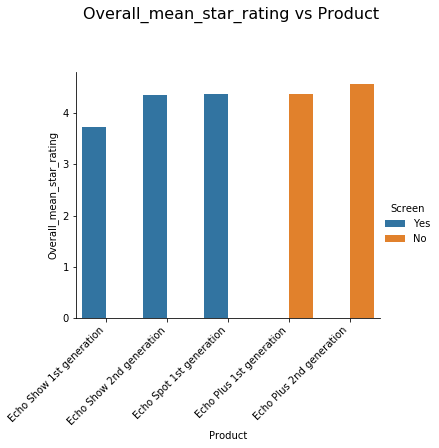

In [11]:
hist_yvar_vs_xvar_onefig(overall_mean,'Product','Overall_mean_star_rating')

<Figure size 1440x432 with 0 Axes>

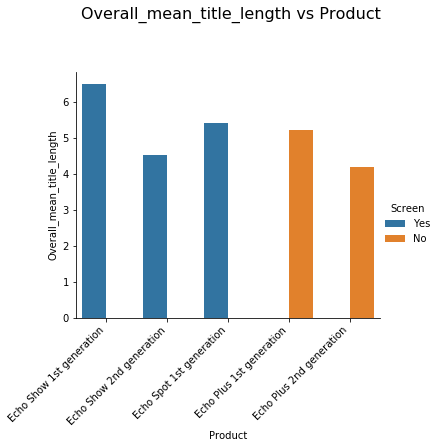

In [12]:
hist_yvar_vs_xvar_onefig(overall_mean,'Product','Overall_mean_title_length')

<Figure size 1440x432 with 0 Axes>

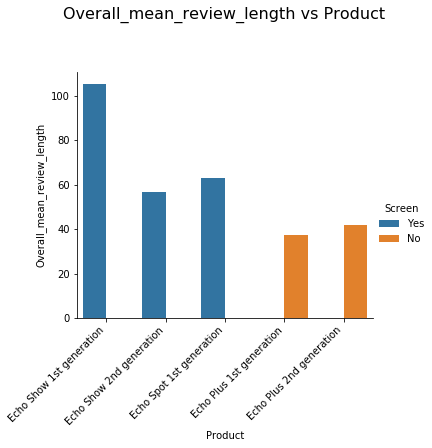

In [13]:
hist_yvar_vs_xvar_onefig(overall_mean,'Product','Overall_mean_review_length')

Overall, all devices appear to have good similar ratings. With the exception of Echo Show 1st Generation (mean star rating = 3.7), the other four devices scored more than 4 stars and the Echo Plus 2nd Generation has the best rating of 4.6. 

The review length was further examined. The mean word counts were calculated from title and contents of reviews for each device. 

<Figure size 1440x432 with 0 Axes>

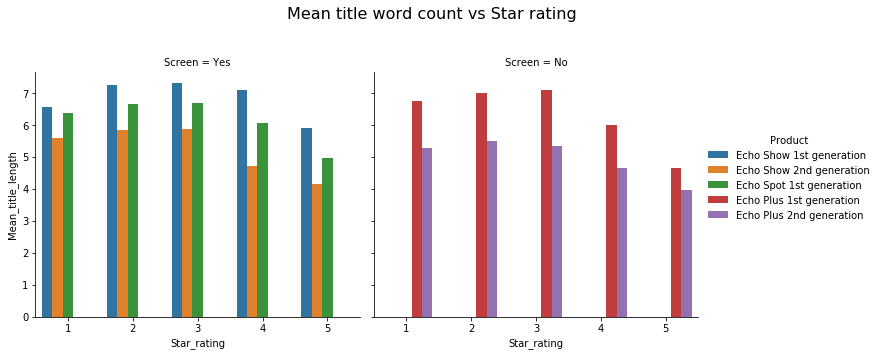

In [14]:
hist_len_vs_star(star_analysis,'title')

<Figure size 1440x432 with 0 Axes>

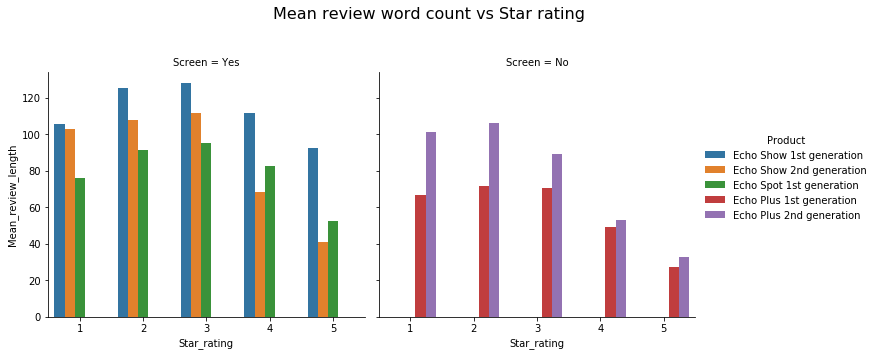

In [15]:
hist_len_vs_star(star_analysis,'review')

As shown above, the titles and review title and contents are shortest for 5-star reviews, and the word counts increase as the star rating decreases. Interestingly, the longest reviews are either 2-star or 3-star reviews, not the 1-star reviews. In addition, reviews for Echo Show and Echo Spot are generally longer than those for Echo Plus. The Echo Show 1st Generation has the longest reviews across all star ratings, while Echo Plus 1st Generation has the shortest reviews. In some cases, the difference is quite significant. For example, the 5-star reviews of Echo Show 1st Generation have 92 words in average, which are 3 times as long as those 5-star reviews from Echo Plus 1st Generation. 

Text(0, 0.5, 'Overall_mean_review_length')

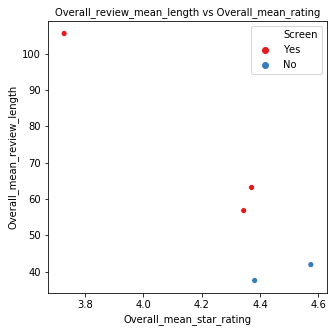

In [16]:
plt_title1 = "Overall_review_mean_length vs Overall_mean_rating"
xcol='Overall_mean_star_rating'
ycol='Overall_mean_review_length'
g1 = plt.figure(figsize=(5,5))
g1 = sns.scatterplot(x=overall_mean[xcol],y=overall_mean[ycol],
                     hue=overall_mean['Screen'],legend="full",palette="Set1")
g1.set_title(plt_title1,fontsize=10)
g1.set_xlabel(xcol,fontsize=10)
g1.set_ylabel(ycol,fontsize=10)

The mean review length was plotted against the mean star rating above, showing that reviewers, when they are not as satisfied with the device as reflected by the lower star rating, would write more. Interestingly, the two screen-less devices, with their relatively higher mean star ratings, have shorter reviews than the three devices with screen. 